# Vehicle Detection Project

This project's goal is to

#1 - Create a classifier that can identify a car
#2 - Create a pipeline that utilizes the classifier to work on images and/or video streams.
#3 - When using video, have the pipeline work with previous known locations of cars to simplify future searches.

In [1]:
#First, load up things we're definitely going to need
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
## Creating a HoG 

## Training a classifier

The datasets we're using are provided by Udacity and assumed to have been extracted into the `data/` folder, separated into `vehicle` and `non-vehicle` folders to keep the dataset labelled. For space reasons, they are not included in the repository, but are provided here:

* [Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip)
* [Non-Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

Here we load up the dataset:

In [10]:
dataset = { "vehicles": [], "nonvehicles": [] }

In [11]:
# Load all of the dataset images
vehicle_dataset_names = [
    "GTI_Far",
    "GTI_Left",
    "GTI_MiddleClose",
    "GTI_Right",
    "KITTI_extracted"
]

non_vehicle_dataset_names = [
    "Extras",
    "GTI"
]

from glob import glob

def get_filenames(folder):
    return glob(folder + "/*.png")

for vehicle_dataset in vehicle_dataset_names:
    dataset['vehicles'] += get_filenames("./data/vehicles/" + vehicle_dataset)
    
for nonvehicle_dataset in non_vehicle_dataset_names:
    dataset['nonvehicles'] += get_filenames("./data/non-vehicles/" + nonvehicle_dataset)


In [13]:
# We need to know if the two datasets are approximately equal before moving on
print("Number of vehicles present in dataset:", len(dataset["vehicles"]))
print("Number of non-vehicles present in dataset:", len(dataset["nonvehicles"]))

Number of vehicles present in dataset: 8792
Number of non-vehicles present in dataset: 8968


We needed to ensure that there were roughly the same number of samples in each vehicle and non-vehicle datasets. Having an imbalance would increase the likelihood that any classifier we created would lean too heavily in just classifying a given input as the majority dataset.

With the above #s, it seems that the culmination of all the datasets provided leads to an approximately equal outcome - we can work with this without having to cull any samples.

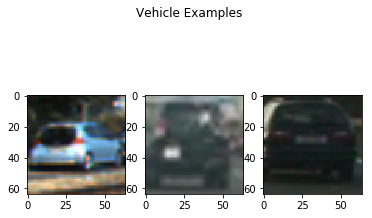

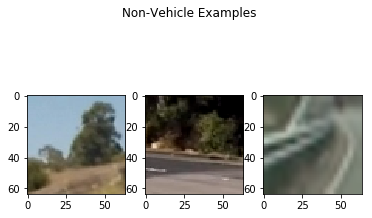

In [29]:
# Load up a couple of random examples of each
from random import randint

example_images_positive = []
example_images_negative = []

fig = plt.figure()
fig.suptitle("Vehicle Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3,i + 1)
    img = cv2.imread(dataset['vehicles'][randint(0, len(dataset['vehicles']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

fig = plt.figure()
fig.suptitle("Non-Vehicle Examples")
for i in range(0, 3):
    fig.add_subplot(1, 3, i + 1)
    img = cv2.imread(dataset['nonvehicles'][randint(0, len(dataset['nonvehicles']))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

### Splitting the Dataset

Now that we have the datasets loaded, we need to split them into training and test datasets.

To do this, we'll make use of sklearn's helper functions.